# **Data Analysis in Python for R Users — R**

# 0. Environment Setup

#### 1. Loading a library

In [1]:
# R uses library() or require() for libraries
if (!require(tidyverse)) install.packages("tidyverse")

# We'll also use a library {naniar} for handling missing values
if (!require(naniar)) install.packages("naniar")

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: naniar



#### 2. Defining custom functions

In [2]:
# Define a custom function affiche() for cleanly printing tables
affiche <- function(df,
                    align = "left",
                    na_color = "\033[91;3m",   # nolint
                    theme = "newspaper") {     # nolint

  # Error handling
  if (ncol(df) == 0 || nrow(df) == 0) { #P
    msg <- "That table doesn't exist!"
    width <- nchar(msg)
    top <- paste0("╔", strrep("═", width + 2), "╗")
    mid <- paste0("║ ", msg, " ║")
    bot <- paste0("╚", strrep("═", width + 2), "╝")
    cat(top, "\n", mid, "\n", bot, "\n", sep = "")
    return(invisible(df))
  }

  # Handle missing rownames
  if (!is.null(rownames(df)) && !any(names(df) == " ")) {
    df <- tibble::rownames_to_column(df, var = " ")
  }


  # Theme setup
  border <- switch(theme,
    "newspaper" = list(
      h = "═", v = "║",
      tl = "╔", tr = "╗",
      bl = "╚", br = "╝",
      jn = "╬",
      l = "╠", r = "╣",
      t = "╦", b = "╩"
    ),
    stop("Theme not supported. Try 'newspaper'")
  )

  # ANSI helpers
  reset <- "\033[0m"
  color_na <- function(x) paste0(na_color, x, reset)

  # Width calculator
  display_width <- function(s) {
    if (is.na(s)) return(2)  # Width of "NA"
    clean <- gsub("\033\\[[0-9;]*[mK]", "", as.character(s))
    nchar(clean, type = "width")
  }

  # --- DATA PREP ---
  df_display <- as.data.frame(
    lapply(df, function(col) {
      ifelse(is.na(col), color_na("NA"), as.character(col))
    }),
    stringsAsFactors = FALSE
  )
  col_names <- names(df_display)

  # Column widths
  col_widths <- sapply(seq_along(col_names), function(i) {
    max(display_width(col_names[i]),
        sapply(df_display[[i]], display_width),
        na.rm = TRUE)
  })

  # Border drawing
  draw_hline <- function(connector_left, connector_right, cross) {
    line <- paste0(
      connector_left,
      paste0(sapply(col_widths, function(w) {
        paste0(strrep(border$h, w + 2), cross)
      }), collapse = "")
    )
    gsub(paste0(cross, "$"), connector_right, line)
  }

  top_line <- draw_hline(border$tl, border$tr, border$t)
  mid_line <- draw_hline(border$l, border$r, border$jn)
  bot_line <- draw_hline(border$bl, border$br, border$b)

  # Header row
  header <- paste0(
    border$v,
    paste0(sapply(seq_along(col_names), function(i) {
      name <- col_names[i]
      width <- col_widths[i]
      pad_total <- width - display_width(name)
      pad_left <- switch(align,
        "left" = 0,
        "center" = floor(pad_total / 2),
        "right" = pad_total
      )
      paste0(" ",
             strrep(" ", pad_left),
             name,
             strrep(" ", pad_total - pad_left),
             " ", border$v)
    }), collapse = "")
  )


  # Data rows
data_rows <- sapply(1:nrow(df_display), function(i) {  # nolint
    paste0(
      border$v,
      paste0(sapply(seq_along(col_names), function(j) {
        content <- df_display[i, j]
        width <- col_widths[j]
        pad_total <- width - display_width(content)
        pad_left <- switch(align,
          "left" = 0,
          "center" = floor(pad_total / 2),
          "right" = pad_total
        )
        paste0(" ",
               strrep(" ", pad_left),
               content,
               strrep(" ", pad_total - pad_left),
               ifelse(j == length(col_names), "", paste0(" ", border$v)))
      }), collapse = ""),
      " ", border$v  # rightmost edge
    )
  })

  # Final assembly
  cat(top_line, "\n")
  cat(header, "\n")
  cat(mid_line, "\n")
  cat(paste0(data_rows, collapse = "\n"), "\n")
  cat(bot_line, "\n")

  invisible(df)
}

In [3]:
# Define a custom function count_table() for generating value counts and percentages
count_table <- function(df, column) {
  df |> 
    group_by({{ column }}) |> 
    summarize(count = n()) |>
    arrange(desc(count)) |>  
    mutate(percent = paste0(round(count / sum(count) * 100, 0), "%")) |> 
    mutate(percent = if_else(percent == "0%" & count >= 1, true = "<1%", false = percent))
}

In [ ]:
# Define a custom function count_na() for counting NA values for each column
count_na <- function(df) {
  result <- tibble(col = character(), na_count = integer())

  for (col in names(df)) {
    # Count missing values per column
    na_count <- df |> filter(is.na(!!sym(col))) |> count() |> pull(n)
    # Place the counts into a result table
    result <- result |> add_row(col = col, na_count = na_count)
  }

  # Add percentage labels 
  result |>
    mutate(
      na_percent = case_when(
        na_count == 0 ~ "0%",
        (na_count / nrow(df)) <= 0.0099 ~ "<1%",
        TRUE ~ paste0(round(na_count / nrow(df) * 100, 0), "%")
      )
    ) |>
    # Sort by missing count
    arrange(desc(na_count))
}

In [ ]:
# Define a custom function describe() for displaying summary stats for numeric cols
describe <- function(df) {
  numeric_df <- df %>%
    select(where(is.numeric))
  
  # Initialize a list to store results
  summary_list <- list()
  
  # Loop through each numeric column and calculate statistics
  for (col in names(numeric_df)) {
    summary_list[[col]] <- c(
      min = min(numeric_df[[col]], na.rm = TRUE),
      max = max(numeric_df[[col]], na.rm = TRUE),
      median = median(numeric_df[[col]], na.rm = TRUE),
      mean = mean(numeric_df[[col]], na.rm = TRUE),
      sd = round(sd(numeric_df[[col]], na.rm = TRUE), 2),
      n = sum(!is.na(numeric_df[[col]]))
    )
  }
  
  # Combine the results into a data frame and transpose
  result <- as.data.frame(do.call(rbind, summary_list))
  
  # Transpose the result to switch rows and columns
  result <- as.data.frame(t(result))
  
  # Set the column names to the measurements
  colnames(result) <- names(numeric_df)
  
  result %>%
    return()
}

# 1. Simple Data

In [8]:
# We use print for displaying something
print("Hello world!")

[1] "Hello world!"


In [ ]:
# Our assignment operator is the arrow (<-)
x <- 10
y <- 20

print(x)
print(y)

[1] 10
[1] 20


In [7]:
# We roughly use the same mathematical operators
z <- x * y
print(z)

a <- x / y
print(a)

b <- x - y
print(b)

[1] 200
[1] 0.5
[1] -10


In [25]:
# Let's look at some data types
k <- 1000
name <- "Henry"
does_exist <- TRUE

# Note: In R, we don't slways have to specify print()
str(k)
str(name)
str(does_exist)

 num 1000
 chr "Henry"


 logi TRUE


In [ ]:
# Missing values operate differently as objects vs as parts of a vector 
# Note: NA_character is the NA placeholder for character strings
null_object <- NULL
na_vector <- c("apple", NA_character_, 25) 

null_object
na_vector

NULL

[1] "apple" NA      "25"

# 2. Working with Dataframes

In [ ]:
# Create a dataframe
# Note: We use NA_real_ for numeric NAs
df <- data.frame(
  Name = c("Henry", "Bob", "Joanne", "Steven"),
  Age = c(22, NA_real_, 30, 48),
  Birthday = c("2003-12-29", "1980-05-15", "1995-01-12", NA_character_)
)

print(df)

    Name Age   Birthday
1  Henry  22 2003-12-29
2    Bob  NA 1980-05-15
3 Joanne  30 1995-01-12
4 Steven  48       <NA>


In [50]:
# Display the structure of the df
str(df)

'data.frame':	4 obs. of  3 variables:
 $ Name    : chr  "Henry" "Bob" "Joanne" "Steven"
 $ Age     : num  22 NA 30 48
 $ Birthday: chr  "2003-12-29" "1980-05-15" "1995-01-12" NA


In [51]:
# Access a single column by name
df$Birthday

[1] "2003-12-29" "1980-05-15" "1995-01-12" NA

In [52]:
# Access the first column by position
column_1 <- df[1]

print(column_1)

    Name
1  Henry
2    Bob
3 Joanne
4 Steven


In [53]:
# Add a new column
df$Fav_Animal <- c("Cat", "Penguin", "Sloth", "Dog")

print(df)

    Name Age   Birthday Fav_Animal
1  Henry  22 2003-12-29        Cat
2    Bob  NA 1980-05-15    Penguin
3 Joanne  30 1995-01-12      Sloth
4 Steven  48       <NA>        Dog


In [234]:
# Drop a column 
df$Age <- NULL

print(df)

    Name   Birthday Fav_Animal
1  Henry 2003-12-29        Cat
2    Bob 1980-05-15    Penguin
3 Joanne 1995-01-12      Sloth
4 Steven 1977-06-05        Dog


In [ ]:
# Convert birthday to a datefield with as.Date()
df$Birthday <- as.Date(df$Birthday)

str(df$Birthday)

 Date[1:4], format: "2003-12-29" "1980-05-15" "1995-01-12" NA


# 3. More Advanced Manipulation

#### 1. Reading in data

In [76]:
# Read in the calls for service data
# Note in R, naming a library before a function is only for conflicts + clarification
cfs <- readr::read_csv("./data/calls_for_service_2025_demo.csv")

# Preview the first ten rows
# Note: We'll start using R's native pipe ( |> ) from here on
cfs |> head(10) |> print()

Rows: 857 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (14): NOPD_Item, Type, TypeText, Priority, InitialType, InitialTypeText...
dbl   (3): MapX, MapY, PoliceDistrict
dttm  (4): TimeCreate, TimeDispatch, TimeArrive, TimeClosed

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 10 × 21
   NOPD_Item Type  TypeText Priority InitialType InitialTypeText InitialPriority
   <chr>     <chr> <chr>    <chr>    <chr>       <chr>           <chr>          
 1 A0000125  94    DISCHAR… 1        94          DISCHARGING FI… 2C             
 2 A0000225  20    AUTO AC… 1        20          AUTO ACCIDENT   1E             
 3 A0000325  94F   FIREWOR… 2J       103         DISTURBANCE (O… 1C             
 4 A0000425  94F   FIREWOR… 2J       103         DISTURBANCE (O… 1C             
 5 A0000525  94    DISCHAR… 2C       94          DISCHARGING FI… 2C             
 6 A0000625  107   SUSPICI… 1        107         SUSPICIOUS PER… 2D             
 7 A0000725  94F   FIREWOR… 1A       94          DISCHARGING FI… 2C             
 8 A0000825  94    DISCHAR… 1        94          DISCHARGING FI… 2C             
 9 A0000925  24    MEDICAL  2D       24          MEDICAL         2D             
10 A0001025  94    DISCHAR… 2C       94          DISCHARGING FI… 2C             
# ℹ 14 m

In [77]:
# Use our custom affiche() function for better readability
cfs |> head(10) |> affiche()

╔════╦═══════════╦══════╦═════════════════════╦══════════╦═════════════╦═════════════════════╦═════════════════╦══════════╦═════════╦═════════════════════════╦═════════════════════════╦═════════════════════════╦═════════════════════════╦═════════════╦════════════════════════╦═══════════════╦══════╦═════════════════════════════╦═══════╦════════════════╦══════════════════════════════════╗ 
║ X. ║ NOPD_Item ║ Type ║ TypeText            ║ Priority ║ InitialType ║ InitialTypeText     ║ InitialPriority ║ MapX     ║ MapY    ║ TimeCreate              ║ TimeDispatch            ║ TimeArrive              ║ TimeClosed              ║ Disposition ║ DispositionText        ║ SelfInitiated ║ Beat ║ BLOCK_ADDRESS               ║ Zip   ║ PoliceDistrict ║ Location                         ║ 
╠════╬═══════════╬══════╬═════════════════════╬══════════╬═════════════╬═════════════════════╬═════════════════╬══════════╬═════════╬═════════════════════════╬═════════════════════════╬═════════════════════════╬═══════

#### 2. Cleaning column names

In [78]:
# Load the {janitor} package from within {tidyverse}
library(janitor)

# Apply the clean_names() function from {janitor}
cfs <- janitor::clean_names(cfs)

str(cfs)

spc_tbl_ [857 × 21] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ nopd_item        : chr [1:857] "A0000125" "A0000225" "A0000325" "A0000425" ...
 $ type             : chr [1:857] "94" "20" "94F" "94F" ...
 $ type_text        : chr [1:857] "DISCHARGING FIREARM" "AUTO ACCIDENT" "FIREWORKS" "FIREWORKS" ...
 $ priority         : chr [1:857] "1" "1" "2J" "2J" ...
 $ initial_type     : chr [1:857] "94" "20" "103" "103" ...
 $ initial_type_text: chr [1:857] "DISCHARGING FIREARM" "AUTO ACCIDENT" "DISTURBANCE (OTHER)" "DISTURBANCE (OTHER)" ...
 $ initial_priority : chr [1:857] "2C" "1E" "1C" "1C" ...
 $ map_x            : num [1:857] 3687148 3680718 3707020 3665351 3664671 ...
 $ map_y            : num [1:857] 539441 529326 561072 536442 536451 ...
 $ time_create      : POSIXct[1:857], format: "2025-01-01 00:01:31" "2025-01-01 00:01:54" ...
 $ time_dispatch    : POSIXct[1:857], format: "2025-01-01 01:49:00" "2025-01-01 03:07:01" ...
 $ time_arrive      : POSIXct[1:857], format: NA "2025-01-01 03:1

In [66]:
# We can select data with select() from {dplyr}
cfs |> select(nopd_item) |> 
  head(10) |> 
  affiche()

╔════╦═══════════╗ 
║ X. ║ nopd_item ║ 
╠════╬═══════════╣ 
║ 1  ║ A0000125  ║
║ 2  ║ A0000225  ║
║ 3  ║ A0000325  ║
║ 4  ║ A0000425  ║
║ 5  ║ A0000525  ║
║ 6  ║ A0000625  ║
║ 7  ║ A0000725  ║
║ 8  ║ A0000825  ║
║ 9  ║ A0000925  ║
║ 10 ║ A0001025  ║ 
╚════╩═══════════╝ 


In [79]:
# Rename columns (in case they weren't already renamed)
# We'll use rename() from {dplyr} from within {tidyverse}
# Where rename wants "new = old"
cfs <- cfs |> rename(zip_code = zip)

# Check on our 19th column
colnames(cfs)[19]

[1] "zip_code"

In [80]:
# Let's see if our column names match now
str(cfs)

# Note: Looks like there are some differences in data types
# We'll try to get these to line up later

spc_tbl_ [857 × 21] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ nopd_item        : chr [1:857] "A0000125" "A0000225" "A0000325" "A0000425" ...
 $ type             : chr [1:857] "94" "20" "94F" "94F" ...
 $ type_text        : chr [1:857] "DISCHARGING FIREARM" "AUTO ACCIDENT" "FIREWORKS" "FIREWORKS" ...
 $ priority         : chr [1:857] "1" "1" "2J" "2J" ...
 $ initial_type     : chr [1:857] "94" "20" "103" "103" ...
 $ initial_type_text: chr [1:857] "DISCHARGING FIREARM" "AUTO ACCIDENT" "DISTURBANCE (OTHER)" "DISTURBANCE (OTHER)" ...
 $ initial_priority : chr [1:857] "2C" "1E" "1C" "1C" ...
 $ map_x            : num [1:857] 3687148 3680718 3707020 3665351 3664671 ...
 $ map_y            : num [1:857] 539441 529326 561072 536442 536451 ...
 $ time_create      : POSIXct[1:857], format: "2025-01-01 00:01:31" "2025-01-01 00:01:54" ...
 $ time_dispatch    : POSIXct[1:857], format: "2025-01-01 01:49:00" "2025-01-01 03:07:01" ...
 $ time_arrive      : POSIXct[1:857], format: NA "2025-01-01 03:1

#### 3. Converting character fields to sentence case

In [81]:
# Use str_to_sentence() from {stringr} via the {tidyverse}
cfs <- cfs |> 
  mutate(across(where(is.character), str_to_sentence))

In [82]:
# Now we can look at the dispositions and see what they look like
# We'll use {dplyr} to group_by() a column, summarize() the count, then arrange() by count
cfs |> 
  group_by(disposition_text) |> 
  summarize(count = n()) |> 
  arrange(desc(count)) |> 
  affiche()

╔════╦═════════════════════════════╦═══════╗ 
║ X. ║ disposition_text            ║ count ║ 
╠════╬═════════════════════════════╬═══════╣ 
║ 1  ║ Necessary action taken      ║ 436   ║
║ 2  ║ Report to follow            ║ 174   ║
║ 3  ║ Gone on arrival             ║ 170   ║
║ 4  ║ Void                        ║ 36    ║
║ 5  ║ Duplicate                   ║ 31    ║
║ 6  ║ Referred to external agency ║ 6     ║
║ 7  ║ Unfounded                   ║ 3     ║
║ 8  ║ Canceled by complainant     ║ 1     ║ 
╚════╩═════════════════════════════╩═══════╝ 


#### 4. Re-casting data types

In [ ]:
# Let's investigate zipcode:
# From now on, we'll use our custom count_table() function

cfs$zip_code |> str()
cfs |> count_table(zip_code) |> affiche()

 chr [1:857] "70117" "70130" "70127" "70118" "70118" "70128" "70122" ...


╔════╦══════════╦═══════╦═════════╗ 
║ X. ║ zip_code ║ count ║ percent ║ 
╠════╬══════════╬═══════╬═════════╣ 
║ 1  ║ 70130    ║ 114   ║ 13%     ║
║ 2  ║ 70119    ║ 96    ║ 11%     ║
║ 3  ║ 70112    ║ 76    ║ 9%      ║
║ 4  ║ 70116    ║ 65    ║ 8%      ║
║ 5  ║ 70126    ║ 58    ║ 7%      ║
║ 6  ║ 70117    ║ 56    ║ 7%      ║
║ 7  ║ 70127    ║ 51    ║ 6%      ║
║ 8  ║ 70124    ║ 50    ║ 6%      ║
║ 9  ║ 70115    ║ 41    ║ 5%      ║
║ 10 ║ 70122    ║ 40    ║ 5%      ║
║ 11 ║ 70118    ║ 38    ║ 4%      ║
║ 12 ║ 70125    ║ 37    ║ 4%      ║
║ 13 ║ 70113    ║ 31    ║ 4%      ║
║ 14 ║ 70114    ║ 29    ║ 3%      ║
║ 15 ║ 70131    ║ 24    ║ 3%      ║
║ 16 ║ 70128    ║ 23    ║ 3%      ║
║ 17 ║ None     ║ 18    ║ 2%      ║
║ 18 ║ 70129    ║ 8     ║ 1%      ║
║ 19 ║ 70148    ║ 2     ║ <1%     ║ 
╚════╩══════════╩═══════╩═════════╝ 


In [ ]:
# Looks like it's a character in R because of this "None" value
# Let's recast it as a numeric
cfs <- cfs |> 
  mutate(zip_code = as.numeric(zip_code))

# Now let's look at zip_code
# And it coerced the "None" for us!
cfs$zip_code |> str()
cfs |> count_table(zip_code) |> affiche()

 num [1:857] 70117 70130 70127 70118 70118 ...


╔════╦══════════╦═══════╦═════════╗ 
║ X. ║ zip_code ║ count ║ percent ║ 
╠════╬══════════╬═══════╬═════════╣ 
║ 1  ║ 70130    ║ 114   ║ 13%     ║
║ 2  ║ 70119    ║ 96    ║ 11%     ║
║ 3  ║ 70112    ║ 76    ║ 9%      ║
║ 4  ║ 70116    ║ 65    ║ 8%      ║
║ 5  ║ 70126    ║ 58    ║ 7%      ║
║ 6  ║ 70117    ║ 56    ║ 7%      ║
║ 7  ║ 70127    ║ 51    ║ 6%      ║
║ 8  ║ 70124    ║ 50    ║ 6%      ║
║ 9  ║ 70115    ║ 41    ║ 5%      ║
║ 10 ║ 70122    ║ 40    ║ 5%      ║
║ 11 ║ 70118    ║ 38    ║ 4%      ║
║ 12 ║ 70125    ║ 37    ║ 4%      ║
║ 13 ║ 70113    ║ 31    ║ 4%      ║
║ 14 ║ 70114    ║ 29    ║ 3%      ║
║ 15 ║ 70131    ║ 24    ║ 3%      ║
║ 16 ║ 70128    ║ 23    ║ 3%      ║
║ 17 ║ NA       ║ 18    ║ 2%      ║
║ 18 ║ 70129    ║ 8     ║ 1%      ║
║ 19 ║ 70148    ║ 2     ║ <1%     ║ 
╚════╩══════════╩═══════╩═════════╝ 


In [86]:
# Let's go back and look at the rest of our datatypes
str(cfs)

tibble [857 × 21] (S3: tbl_df/tbl/data.frame)
 $ nopd_item        : chr [1:857] "A0000125" "A0000225" "A0000325" "A0000425" ...
 $ type             : chr [1:857] "94" "20" "94f" "94f" ...
 $ type_text        : chr [1:857] "Discharging firearm" "Auto accident" "Fireworks" "Fireworks" ...
 $ priority         : chr [1:857] "1" "1" "2j" "2j" ...
 $ initial_type     : chr [1:857] "94" "20" "103" "103" ...
 $ initial_type_text: chr [1:857] "Discharging firearm" "Auto accident" "Disturbance (other)" "Disturbance (other)" ...
 $ initial_priority : chr [1:857] "2c" "1e" "1c" "1c" ...
 $ map_x            : num [1:857] 3687148 3680718 3707020 3665351 3664671 ...
 $ map_y            : num [1:857] 539441 529326 561072 536442 536451 ...
 $ time_create      : POSIXct[1:857], format: "2025-01-01 00:01:31" "2025-01-01 00:01:54" ...
 $ time_dispatch    : POSIXct[1:857], format: "2025-01-01 01:49:00" "2025-01-01 03:07:01" ...
 $ time_arrive      : POSIXct[1:857], format: NA "2025-01-01 03:12:25" ...
 $ t

In [ ]:
# Let's investigate the time_create column 
cfs |> 
  count_table(time_create) |> 
  affiche()

╔═════╦═════════════════════════╦═══════╦═════════╗ 
║ X.  ║ time_create             ║ count ║ percent ║ 
╠═════╬═════════════════════════╬═══════╬═════════╣ 
║ 1   ║ 2025-01-01 00:01:31.77  ║ 1     ║ <1%     ║
║ 2   ║ 2025-01-01 00:01:54.433 ║ 1     ║ <1%     ║
║ 3   ║ 2025-01-01 00:01:55.25  ║ 1     ║ <1%     ║
║ 4   ║ 2025-01-01 00:02:04.403 ║ 1     ║ <1%     ║
║ 5   ║ 2025-01-01 00:03:08.487 ║ 1     ║ <1%     ║
║ 6   ║ 2025-01-01 00:03:14.237 ║ 1     ║ <1%     ║
║ 7   ║ 2025-01-01 00:03:36.93  ║ 1     ║ <1%     ║
║ 8   ║ 2025-01-01 00:03:48.55  ║ 1     ║ <1%     ║
║ 9   ║ 2025-01-01 00:05:07.61  ║ 1     ║ <1%     ║
║ 10  ║ 2025-01-01 00:05:34.307 ║ 1     ║ <1%     ║
║ 11  ║ 2025-01-01 00:05:39.653 ║ 1     ║ <1%     ║
║ 12  ║ 2025-01-01 00:05:49.737 ║ 1     ║ <1%     ║
║ 13  ║ 2025-01-01 00:05:56.763 ║ 1     ║ <1%     ║
║ 14  ║ 2025-01-01 00:07:05.61  ║ 1     ║ <1%     ║
║ 15  ║ 2025-01-01 00:07:19.077 ║ 1     ║ <1%     ║
║ 16  ║ 2025-01-01 00:07:47.137 ║ 1     ║ <1%     ║
║ 17  ║ 2

In [343]:
# We can tell that R recognizes our date fields correctly (POSIXct)
# But we could re-cast them if they were stored as character strings
time_cols <- c("time_create", "time_dispatch", "time_arrive", "time_closed")

for (col in time_cols) {
  cfs[[col]] <- as.POSIXct(cfs[[col]])
}

# Now let's select() the date columns and see their datatypes
# Note: We'll use a handy argument within select() called all_of()
cfs |> select(all_of(time_cols)) |> str()

tibble [857 × 4] (S3: tbl_df/tbl/data.frame)
 $ time_create  : POSIXct[1:857], format: "2025-01-01 00:01:31" "2025-01-01 00:01:54" ...
 $ time_dispatch: POSIXct[1:857], format: "2025-01-01 01:49:00" "2025-01-01 03:07:01" ...
 $ time_arrive  : POSIXct[1:857], format: NA "2025-01-01 03:12:25" ...
 $ time_closed  : POSIXct[1:857], format: "2025-01-01 01:57:09" "2025-01-01 06:54:17" ...


In [ ]:
# Let's go back to our columns
# And all of our datatypes look pretty good
str(cfs)

tibble [857 × 21] (S3: tbl_df/tbl/data.frame)
 $ nopd_item        : chr [1:857] "A0000125" "A0000225" "A0000325" "A0000425" ...
 $ type             : chr [1:857] "94" "20" "94f" "94f" ...
 $ type_text        : chr [1:857] "Discharging firearm" "Auto accident" "Fireworks" "Fireworks" ...
 $ priority         : chr [1:857] "1" "1" "2j" "2j" ...
 $ initial_type     : chr [1:857] "94" "20" "103" "103" ...
 $ initial_type_text: chr [1:857] "Discharging firearm" "Auto accident" "Disturbance (other)" "Disturbance (other)" ...
 $ initial_priority : chr [1:857] "2c" "1e" "1c" "1c" ...
 $ map_x            : num [1:857] 3687148 3680718 3707020 3665351 3664671 ...
 $ map_y            : num [1:857] 539441 529326 561072 536442 536451 ...
 $ time_create      : POSIXct[1:857], format: "2025-01-01 00:01:31" "2025-01-01 00:01:54" ...
 $ time_dispatch    : POSIXct[1:857], format: "2025-01-01 01:49:00" "2025-01-01 03:07:01" ...
 $ time_arrive      : POSIXct[1:857], format: NA "2025-01-01 03:12:25" ...
 $ t

#### 5. Replacing missing values

##### A. Replacing 0s

In [87]:
# With some digging, we can find that some columns have 0s 
# They're map_x, map_y, and police_district '
# Here's police district 
cfs |> 
  count_table(police_district) |> 
  affiche()

╔════╦═════════════════╦═══════╦═════════╗ 
║ X. ║ police_district ║ count ║ percent ║ 
╠════╬═════════════════╬═══════╬═════════╣ 
║ 1  ║ 8               ║ 193   ║ 23%     ║
║ 2  ║ 3               ║ 137   ║ 16%     ║
║ 3  ║ 7               ║ 119   ║ 14%     ║
║ 4  ║ 1               ║ 101   ║ 12%     ║
║ 5  ║ 6               ║ 89    ║ 10%     ║
║ 6  ║ 2               ║ 79    ║ 9%      ║
║ 7  ║ 5               ║ 76    ║ 9%      ║
║ 8  ║ 4               ║ 55    ║ 6%      ║
║ 9  ║ 0               ║ 8     ║ 1%      ║ 
╚════╩═════════════════╩═══════╩═════════╝ 


In [88]:
# Replace 0s in map_x, map_y, and police_district 
zero_cols <- c("map_x", "map_y", "police_district")

# In R, we'll use a handy function from {naniar}
cfs <- cfs %>% 
  naniar::replace_with_na_at(.vars = zero_cols, ~.x == 0)

# Now, let's see what police districts look like
cfs |> 
  count_table(police_district) |> 
  affiche()

╔════╦═════════════════╦═══════╦═════════╗ 
║ X. ║ police_district ║ count ║ percent ║ 
╠════╬═════════════════╬═══════╬═════════╣ 
║ 1  ║ 8               ║ 193   ║ 23%     ║
║ 2  ║ 3               ║ 137   ║ 16%     ║
║ 3  ║ 7               ║ 119   ║ 14%     ║
║ 4  ║ 1               ║ 101   ║ 12%     ║
║ 5  ║ 6               ║ 89    ║ 10%     ║
║ 6  ║ 2               ║ 79    ║ 9%      ║
║ 7  ║ 5               ║ 76    ║ 9%      ║
║ 8  ║ 4               ║ 55    ║ 6%      ║
║ 9  ║ NA              ║ 8     ║ 1%      ║ 
╚════╩═════════════════╩═══════╩═════════╝ 


##### B. Replacing Nones

In [90]:
# After more digging, you'll find that both beat also has some "None" values
cfs |> count_table(beat) |> 
  filter(beat == "None") |> 
  affiche()

╔════╦══════╦═══════╦═════════╗ 
║ X. ║ beat ║ count ║ percent ║ 
╠════╬══════╬═══════╬═════════╣ 
║ 1  ║ None ║ 9     ║ 1%      ║ 
╚════╩══════╩═══════╩═════════╝ 


In [91]:
# We can use the same approach we used with replacing 0s
cfs <- cfs %>% 
  naniar::replace_with_na_at(.vars = "beat", ~.x == "None")

# Now let's see if they were succesfully transormed to NAs
cfs |> count_table(beat) |> 
  filter(is.na(beat)) |> 
  affiche()

╔════╦══════╦═══════╦═════════╗ 
║ X. ║ beat ║ count ║ percent ║ 
╠════╬══════╬═══════╬═════════╣ 
║ 1  ║ NA   ║ 9     ║ 1%      ║ 
╚════╩══════╩═══════╩═════════╝ 


In [92]:
# Now we can look at our missing values by column:
cfs |> count_na() |> affiche()

╔════╦═══════════════════╦══════════╦════════════╗ 
║ X. ║ col               ║ na_count ║ na_percent ║ 
╠════╬═══════════════════╬══════════╬════════════╣ 
║ 1  ║ time_dispatch     ║ 473      ║ 55%        ║
║ 2  ║ time_arrive       ║ 240      ║ 28%        ║
║ 3  ║ zip_code          ║ 18       ║ 2%         ║
║ 4  ║ beat              ║ 9        ║ 1%         ║
║ 5  ║ map_x             ║ 8        ║ <1%        ║
║ 6  ║ map_y             ║ 8        ║ <1%        ║
║ 7  ║ police_district   ║ 8        ║ <1%        ║
║ 8  ║ nopd_item         ║ 0        ║ 0%         ║
║ 9  ║ type              ║ 0        ║ 0%         ║
║ 10 ║ type_text         ║ 0        ║ 0%         ║
║ 11 ║ priority          ║ 0        ║ 0%         ║
║ 12 ║ initial_type      ║ 0        ║ 0%         ║
║ 13 ║ initial_type_text ║ 0        ║ 0%         ║
║ 14 ║ initial_priority  ║ 0        ║ 0%         ║
║ 15 ║ time_create       ║ 0        ║ 0%         ║
║ 16 ║ time_closed       ║ 0        ║ 0%         ║
║ 17 ║ disposition       ║ 0

#### 6. Using regex to update a column

In [ ]:
# Next, let's take a look at other unexpected beat values
# We're looking for strings that don't follow the conventional pattern of ...
# ... 1 digit followed by 1 letter, then 2 more digits (eg 1b01)
# This is a common issue resulting from programs like Excel auto-parsing certain fields
# Basically, we want 1.00e+03 to become 1e03, etc 
# We'll create a new column with an if_else() requiring a condition and arguments for true or false
cfs <- cfs |> mutate(
  beat_2 = if_else(
    condition = !grepl("\\d{1}[a-z]\\d{2}", beat) & !is.na(beat),
    true = str_replace(beat, 
                       pattern = "(\\d{1})\\.00(e)\\+(\\d{2})", 
                       replacement = "\\1\\2\\3"),
    false = beat 
    )
  ) 

cfs |> 
  filter(!grepl("\\d{1}[a-z]\\d{2}", beat) & !is.na(beat)) |> 
  distinct(beat, beat_2) |> 
  affiche()

╔════╦══════════╦════════╗ 
║ X. ║ beat     ║ beat_2 ║ 
╠════╬══════════╬════════╣ 
║ 1  ║ 1.00e+03 ║ 1e03   ║
║ 2  ║ 5.00e+01 ║ 5e01   ║
║ 3  ║ 8.00e+05 ║ 8e05   ║
║ 4  ║ 3.00e+02 ║ 3e02   ║
║ 5  ║ 4.00e+03 ║ 4e03   ║
║ 6  ║ 8.00e+03 ║ 8e03   ║
║ 7  ║ 6.00e+02 ║ 6e02   ║
║ 8  ║ 8.00e+02 ║ 8e02   ║
║ 9  ║ 6.00e+01 ║ 6e01   ║
║ 10 ║ 2.00e+02 ║ 2e02   ║
║ 11 ║ 1.00e+01 ║ 1e01   ║
║ 12 ║ 5.00e+04 ║ 5e04   ║
║ 13 ║ 8.00e+04 ║ 8e04   ║
║ 14 ║ 1.00e+04 ║ 1e04   ║
║ 15 ║ 7.00e+01 ║ 7e01   ║
║ 16 ║ 8.00e+01 ║ 8e01   ║
║ 17 ║ 3.00e+01 ║ 3e01   ║
║ 18 ║ 5.00e+02 ║ 5e02   ║
║ 19 ║ 6.00e+04 ║ 6e04   ║
║ 20 ║ 4.00e+04 ║ 4e04   ║
║ 21 ║ 2.00e+01 ║ 2e01   ║
║ 22 ║ 5.00e+03 ║ 5e03   ║ 
╚════╩══════════╩════════╝ 


In [351]:
# Now we can update beat with our beat_2 column
cfs$beat <- cfs$beat_2

# Then drop the beat_2 column
cfs$beat_2 <- NULL

# And look at the new beat values that were updated
cfs |> 
  count_table(beat) |> 
  filter(grepl("e", beat)) |> 
  affiche()

╔════╦══════╦═══════╦═════════╗ 
║ X. ║ beat ║ count ║ percent ║ 
╠════╬══════╬═══════╬═════════╣ 
║ 1  ║ 1e01 ║ 9     ║ 1%      ║
║ 2  ║ 8e05 ║ 9     ║ 1%      ║
║ 3  ║ 1e03 ║ 8     ║ 1%      ║
║ 4  ║ 3e02 ║ 6     ║ 1%      ║
║ 5  ║ 4e04 ║ 6     ║ 1%      ║
║ 6  ║ 5e01 ║ 5     ║ 1%      ║
║ 7  ║ 8e02 ║ 5     ║ 1%      ║
║ 8  ║ 8e03 ║ 5     ║ 1%      ║
║ 9  ║ 2e02 ║ 4     ║ <1%     ║
║ 10 ║ 8e01 ║ 4     ║ <1%     ║
║ 11 ║ 7e01 ║ 3     ║ <1%     ║
║ 12 ║ 8e04 ║ 3     ║ <1%     ║
║ 13 ║ 1e04 ║ 2     ║ <1%     ║
║ 14 ║ 4e03 ║ 2     ║ <1%     ║
║ 15 ║ 5e02 ║ 2     ║ <1%     ║
║ 16 ║ 5e03 ║ 2     ║ <1%     ║
║ 17 ║ 5e04 ║ 2     ║ <1%     ║
║ 18 ║ 6e01 ║ 2     ║ <1%     ║
║ 19 ║ 6e02 ║ 2     ║ <1%     ║
║ 20 ║ 6e04 ║ 2     ║ <1%     ║
║ 21 ║ 2e01 ║ 1     ║ <1%     ║
║ 22 ║ 3e01 ║ 1     ║ <1%     ║ 
╚════╩══════╩═══════╩═════════╝ 


#### 7. Creating booleans

In [93]:
# It looks like self-initiated uses a Y / N system 
cfs |> 
  count_table(self_initiated) |> 
  affiche()

╔════╦════════════════╦═══════╦═════════╗ 
║ X. ║ self_initiated ║ count ║ percent ║ 
╠════╬════════════════╬═══════╬═════════╣ 
║ 1  ║ N              ║ 646   ║ 75%     ║
║ 2  ║ Y              ║ 211   ║ 25%     ║ 
╚════╩════════════════╩═══════╩═════════╝ 


In [94]:
# So we're going to make it a boolean instead with another if_else()
cfs <- cfs |> mutate(self_initiated = if_else(
  condition = self_initiated == "Y",
  true = TRUE,
  false = FALSE)
)

In [96]:
# Let's see how that turned out
str(cfs$self_initiated)

cfs |> 
  count_table(self_initiated) |> 
  affiche()

 logi [1:857] FALSE FALSE FALSE FALSE FALSE FALSE ...
╔════╦════════════════╦═══════╦═════════╗ 
║ X. ║ self_initiated ║ count ║ percent ║ 
╠════╬════════════════╬═══════╬═════════╣ 
║ 1  ║ FALSE          ║ 646   ║ 75%     ║
║ 2  ║ TRUE           ║ 211   ║ 25%     ║ 
╚════╩════════════════╩═══════╩═════════╝ 


#### 8. Extracting coordinate info

In [97]:
# Let's take a look at the location field
str(cfs$location)

cfs |> select(location) |> head(5) |> affiche()

 chr [1:857] "Point (-90.04995412 29.97710343)" ...


╔════╦══════════════════════════════════╗ 
║ X. ║ location                         ║ 
╠════╬══════════════════════════════════╣ 
║ 1  ║ Point (-90.04995412 29.97710343) ║
║ 2  ║ Point (-90.07061588 29.94948919) ║
║ 3  ║ Point (-89.98638954 30.03595457) ║
║ 4  ║ Point (-90.11889699 29.96951243) ║
║ 5  ║ Point (-90.12104322 29.96955652) ║ 
╚════╩══════════════════════════════════╝ 


In [98]:
# Let's extract the longitude field from the location column
# And coerce as numeric type

# Key: \\- is a double-escaped search for a hyphen 
# \\d{2} is a double-escaped search for two digits
# \\. is a double-escaped search for a decimal
# and \\d{4,} is a double-escaped search for four or more digits
longitude_pattern <- "(\\-\\d{2}\\.\\d{4,})"
cfs$longitude <- cfs$location |> str_extract(longitude_pattern) |> as.numeric()

cfs |> select(longitude) |> head(5) |> affiche()

╔════╦══════════════╗ 
║ X. ║ longitude    ║ 
╠════╬══════════════╣ 
║ 1  ║ -90.04995412 ║
║ 2  ║ -90.07061588 ║
║ 3  ║ -89.98638954 ║
║ 4  ║ -90.11889699 ║
║ 5  ║ -90.12104322 ║ 
╚════╩══════════════╝ 


In [99]:
# Let's extract the latitude field from the location column
# And coerce as numeric type

# Key: \\s is a double-escaped search for a whitespace
# \\d{2} is a double-escaped search for two digits
# \\. is a double-escaped search for a decimla
# and \\d{4,} is a double-escaped search for four or more digits
latitude_pattern <- "\\s(\\d{2}\\.\\d{4,})"
cfs$latitude <- cfs$location |> str_extract(latitude_pattern) |> as.numeric()

cfs |> select(latitude) |> head(5) |> affiche()

╔════╦═════════════╗ 
║ X. ║ latitude    ║ 
╠════╬═════════════╣ 
║ 1  ║ 29.97710343 ║
║ 2  ║ 29.94948919 ║
║ 3  ║ 30.03595457 ║
║ 4  ║ 29.96951243 ║
║ 5  ║ 29.96955652 ║ 
╚════╩═════════════╝ 


#### 9. Geocoding missing location data

In [100]:
# We'll load {glue} in R for handy string interpolation
if (!require(glue)) install.packages("glue")

# Identify cases with missing location data
missing <- cfs |> 
  filter(is.na(longitude) & is.na(latitude)) |> 
  filter(!is.na(block_address)) 
  
missing |> 
  select(block_address, zip_code, location:latitude) |> 
  head(10) |> 
  affiche()

print(glue("Number of missing location fields: {nrow(missing)}"))

Loading required package: glue



╔════╦═══════════════════════════╦══════════╦═════════════╦═══════════╦══════════╗ 
║ X. ║ block_address             ║ zip_code ║ location    ║ longitude ║ latitude ║ 
╠════╬═══════════════════════════╬══════════╬═════════════╬═══════════╬══════════╣ 
║ 1  ║ St peter st & dauphine st ║ 70112    ║ Point (0 0) ║ NA        ║ NA       ║
║ 2  ║ 023xx blk nashville av    ║ 70115    ║ Point (0 0) ║ NA        ║ NA       ║
║ 3  ║ 020xx tupelo st           ║ 70117    ║ Point (0 0) ║ NA        ║ NA       ║
║ 4  ║ 038xx general pershing st ║ 70125    ║ Point (0 0) ║ NA        ║ NA       ║
║ 5  ║ 054xx eads st             ║ 70122    ║ Point (0 0) ║ NA        ║ NA       ║
║ 6  ║ 6th st & prytania st      ║ 70115    ║ Point (0 0) ║ NA        ║ NA       ║
║ 7  ║ 030xx oliver white av     ║ 70126    ║ Point (0 0) ║ NA        ║ NA       ║
║ 8  ║ 008xx blk conti st        ║ 70112    ║ Point (0 0) ║ NA        ║ NA       ║
║ 9  ║ 008xx conti st            ║ 70112    ║ Point (0 0) ║ NA        ║ NA       ║
║

In [359]:
# Load the {tidygeocoder} package
if (!require(tidygeocoder)) install.packages("tidygeocoder")

# Let's fill out an address field
missing$address <- paste(missing$block_address, "Louisiana, LA", missing$zipcode)

missing |> 
  select(block_address, address) |> 
  head(10) |> 
  affiche()

missing <- missing |> 
  tidygeocoder::geocode(address = address,
                        method = "arcgis",
                        lat = latitude,
                        long = longitude)

╔════╦═══════════════════════════╦═══════════════════════════════════════════════╗ 
║ X. ║ block_address             ║ address                                       ║ 
╠════╬═══════════════════════════╬═══════════════════════════════════════════════╣ 
║ 1  ║ St peter st & dauphine st ║ St peter st & dauphine st Louisiana, LA 70112 ║
║ 2  ║ 023xx blk nashville av    ║ 023xx blk nashville av Louisiana, LA 70115    ║
║ 3  ║ 020xx tupelo st           ║ 020xx tupelo st Louisiana, LA 70117           ║
║ 4  ║ 038xx general pershing st ║ 038xx general pershing st Louisiana, LA 70125 ║
║ 5  ║ 054xx eads st             ║ 054xx eads st Louisiana, LA 70122             ║
║ 6  ║ 6th st & prytania st      ║ 6th st & prytania st Louisiana, LA 70115      ║
║ 7  ║ 030xx oliver white av     ║ 030xx oliver white av Louisiana, LA 70126     ║
║ 8  ║ 008xx blk conti st        ║ 008xx blk conti st Louisiana, LA 70112        ║
║ 9  ║ 008xx conti st            ║ 008xx conti st Louisiana, LA 70112            ║
║

Passing 47 addresses to the ArcGIS single address geocoder

Query completed in: 25.4 seconds

New names:
• `longitude` -> `longitude...22`
• `latitude` -> `latitude...23`
• `latitude` -> `latitude...25`
• `longitude` -> `longitude...26`


In [360]:
# First let's fix the new latitude and longitude columns
# Since R renamed all four of our columns, we'll just use the new columns
missing <- missing |> 
  rename(latitude = latitude...25,
         longitude = longitude...26)

# Now let's look at the geocoded addresses
missing |> 
  select(address:longitude) |> 
  head(10) |> 
  affiche()           

╔════╦═══════════════════════════════════════════════╦═════════════════╦══════════════════╗ 
║ X. ║ address                                       ║ latitude        ║ longitude        ║ 
╠════╬═══════════════════════════════════════════════╬═════════════════╬══════════════════╣ 
║ 1  ║ St peter st & dauphine st Louisiana, LA 70112 ║ 29.959194702077 ║ -90.066575319537 ║
║ 2  ║ 023xx blk nashville av Louisiana, LA 70115    ║ 29.915627025434 ║ -90.120427976315 ║
║ 3  ║ 020xx tupelo st Louisiana, LA 70117           ║ 29.964454291919 ║ -90.009001358431 ║
║ 4  ║ 038xx general pershing st Louisiana, LA 70125 ║ 29.9469359129   ║ -90.102865350646 ║
║ 5  ║ 054xx eads st Louisiana, LA 70122             ║ 30.0196796979   ║ -90.050490621894 ║
║ 6  ║ 6th st & prytania st Louisiana, LA 70115      ║ 29.928962979433 ║ -90.086461971554 ║
║ 7  ║ 030xx oliver white av Louisiana, LA 70126     ║ 29.988962780925 ║ -90.033823766913 ║
║ 8  ║ 008xx blk conti st Louisiana, LA 70112        ║ 29.960412264014 ║ -90.

In [361]:
# Let's double-check if there are any missing coordinates
missing |> 
  filter(is.na(latitude) | is.na(longitude)) |> 
  head(10) |> 
  affiche()

╔═══════════════════════════╗
║ That table doesn't exist! ║
╚═══════════════════════════╝


In [ ]:
# Now let's join them back to the original cfs table
cfs <- cfs %>% 
  left_join(missing |> select(block_address, 
                              latitude, 
                              longitude), 
            by = "block_address")

# We'll update the original longitude and latitude values with the new ones via coalesce(), ...
# ... drop the extra columns, and rename the original columns
cfs <- cfs |> 
  mutate(longitude.x = coalesce(longitude.x, longitude.y),
         latitude.x = coalesce(latitude.x, latitude.y)) |> 
  select(-c(longitude.y, latitude.y)) |> 
  rename(longitude = longitude.x, 
         latitude = latitude.x)

str(cfs)

tibble [857 × 23] (S3: tbl_df/tbl/data.frame)
 $ nopd_item        : chr [1:857] "A0000125" "A0000225" "A0000325" "A0000425" ...
 $ type             : chr [1:857] "94" "20" "94f" "94f" ...
 $ type_text        : chr [1:857] "Discharging firearm" "Auto accident" "Fireworks" "Fireworks" ...
 $ priority         : chr [1:857] "1" "1" "2j" "2j" ...
 $ initial_type     : chr [1:857] "94" "20" "103" "103" ...
 $ initial_type_text: chr [1:857] "Discharging firearm" "Auto accident" "Disturbance (other)" "Disturbance (other)" ...
 $ initial_priority : chr [1:857] "2c" "1e" "1c" "1c" ...
 $ map_x            : num [1:857] 3687148 3680718 3707020 3665351 3664671 ...
 $ map_y            : num [1:857] 539441 529326 561072 536442 536451 ...
 $ time_create      : POSIXct[1:857], format: "2025-01-01 00:01:31" "2025-01-01 00:01:54" ...
 $ time_dispatch    : POSIXct[1:857], format: "2025-01-01 01:49:00" "2025-01-01 03:07:01" ...
 $ time_arrive      : POSIXct[1:857], format: NA "2025-01-01 03:12:25" ...
 $ t

#### 10. Calculating response time

In [ ]:
# Calculate response time (from when call was created to when the officer arrived)
cfs <- cfs |> 
  mutate(response_time = (time_arrive - time_create) |> round(2),
    .after = time_arrive
  )

# We see some zeroes here — let's make them NA
cfs <- cfs %>% 
  naniar::replace_with_na_at(.vars = "response_time", ~.x == "0")

# Look at the longest response times
cfs |> 
  select(time_create:response_time) |> 
  filter(!is.na(time_arrive)) |> 
  arrange(desc(response_time)) |> 
  head(10) |> 
  affiche()

╔════╦═════════════════════════╦══════╦═════════════╦═════════════════════════╦═════════════════════════╦═══════════════╗ 
║ X. ║ time_create             ║ hour ║ time_period ║ time_dispatch           ║ time_arrive             ║ response_time ║ 
╠════╬═════════════════════════╬══════╬═════════════╬═════════════════════════╬═════════════════════════╬═══════════════╣ 
║ 1  ║ 2025-01-01 03:30:45.437 ║ 3    ║ Night       ║ 2025-01-02 08:39:32.507 ║ 2025-01-02 08:52:25.433 ║ 105700        ║
║ 2  ║ 2025-01-01 09:37:39.953 ║ 9    ║ Morning     ║ 2025-01-02 09:02:45.143 ║ 2025-01-02 09:10:51.553 ║ 84791.6       ║
║ 3  ║ 2025-01-01 08:29:57.033 ║ 8    ║ Morning     ║ 2025-01-02 02:56:37.437 ║ 2025-01-02 03:41:47.143 ║ 69110.11      ║
║ 4  ║ 2025-01-01 04:02:41.267 ║ 4    ║ Night       ║ 2025-01-01 21:39:33.843 ║ 2025-01-01 21:52:04.913 ║ 64163.65      ║
║ 5  ║ 2025-01-01 18:22:00.29  ║ 18   ║ Evening     ║ 2025-01-02 09:14:06.077 ║ 2025-01-02 09:22:53.993 ║ 54053.7       ║
║ 6  ║ 2025-01-01 09:

In [393]:
# Let's look at that case with the longest response time
cfs |> filter(response_time == "105700") |> affiche()

╔════╦═══════════╦══════╦════════════════╦══════════╦═══════════════╦══════════════╦═══════════════════╦══════════════════╦══════════╦═════════╦═════════════════════════╦══════╦═════════════╦═════════════════════════╦═════════════════════════╦═══════════════╦════════════════════════╦═════════════╦══════════════════╦════════════════╦══════╦═══════════════════╦═════════╦═════════════════╦═════════════╦══════════════════╦═════════════════╦══════════╗ 
║ X. ║ nopd_item ║ type ║ type_text      ║ priority ║ priority_desc ║ initial_type ║ initial_type_text ║ initial_priority ║ map_x    ║ map_y   ║ time_create             ║ hour ║ time_period ║ time_dispatch           ║ time_arrive             ║ response_time ║ time_closed            ║ disposition ║ disposition_text ║ self_initiated ║ beat ║ block_address     ║ zipcode ║ police_district ║ location    ║ longitude        ║ latitude        ║ category ║ 
╠════╬═══════════╬══════╬════════════════╬══════════╬═══════════════╬══════════════╬══════════

#### 11. Collapsing call priorities

In [365]:
# We'll collapse the call priorities using the descriptions given from the codebook
cfs <- cfs |> 
  mutate(
    priority_desc = case_when(
      grepl("0", priority) ~ "Non-police",
      grepl("1", priority) ~ "Non-emergency",
      grepl("2", priority) ~ "Emergency",
      grepl("3", priority) ~ "Officer assistance"
    ), .after = priority
  )

In [366]:
# Take a look at the new priority descriptions
cfs |> count_table(priority_desc) |> affiche()

╔════╦════════════════════╦═══════╦═════════╗ 
║ X. ║ priority_desc      ║ count ║ percent ║ 
╠════╬════════════════════╬═══════╬═════════╣ 
║ 1  ║ Non-emergency      ║ 583   ║ 68%     ║
║ 2  ║ Emergency          ║ 213   ║ 25%     ║
║ 3  ║ Non-police         ║ 60    ║ 7%      ║
║ 4  ║ Officer assistance ║ 1     ║ <1%     ║ 
╚════╩════════════════════╩═══════╩═════════╝ 


#### 12. Classifying call types

In [367]:
# Define keywords for violent crimes
violent_keywords <- c("assault", "battery", "homicide", "fight", "rape", "carjacking")

# Define keywords for theft crimes
theft_keywords <- c("theft", "burglary", "stolen", "shoplifting", "damage")

# Define keywords for traffic incidents
traffic_keywords <- c("traffic", "driving", "tow", "accident", "stranded")

# Categorize calls
cfs <- cfs |> 
  mutate(
    is_violent = str_detect(tolower(type_text), paste(violent_keywords, collapse = "|")), 
    is_theft = str_detect(tolower(type_text), paste(theft_keywords, collapse = "|")),  
    is_traffic = str_detect(tolower(type_text), paste(traffic_keywords, collapse = "|")), 
    category = case_when(
      is_violent == TRUE ~ "Violent",
      is_theft == TRUE ~ "Theft", 
      is_traffic == TRUE ~ "Traffic", 
      TRUE ~ "Other")
  ) |> 
  select(-c(is_violent:is_traffic))

# 4. Exploratory Data Analysis

#### 1. Summary statistics

In [368]:
# Use our custom describe() function for pulling summary stats
cfs |> describe() |> affiche()

╔════════╦══════════════════╦══════════════════╦═════════════════╦═══════════════════╦══════════════════╗ 
║ X.     ║ map_x            ║ map_y            ║ police_district ║ longitude         ║ latitude         ║ 
╠════════╬══════════════════╬══════════════════╬═════════════════╬═══════════════════╬══════════════════╣ 
║ min    ║ 3660508          ║ 510890           ║ 1               ║ -90.13435318      ║ 29.89809981      ║
║ max    ║ 37369000         ║ 3513814          ║ 8               ║ -89.88037655      ║ 30.12384063      ║
║ median ║ 3681869          ║ 534639           ║ 5               ║ -90.0680996       ║ 29.96201054      ║
║ mean   ║ 5231291.56419317 ║ 674430.623085984 ║ 4.924617196702  ║ -90.0608177487185 ║ 29.9722506123582 ║
║ sd     ║ 7056045.87       ║ 623529.98        ║ 2.48            ║ 0.04              ║ 0.03             ║
║ n      ║ 849              ║ 849              ║ 849             ║ 857               ║ 857              ║ 
╚════════╩══════════════════╩═════════════

#### 2. What are the most commonly occuring call type categories?

In [369]:
cfs |> count_table(category) |> affiche()

╔════╦══════════╦═══════╦═════════╗ 
║ X. ║ category ║ count ║ percent ║ 
╠════╬══════════╬═══════╬═════════╣ 
║ 1  ║ Other    ║ 664   ║ 77%     ║
║ 2  ║ Traffic  ║ 76    ║ 9%      ║
║ 3  ║ Theft    ║ 65    ║ 8%      ║
║ 4  ║ Violent  ║ 52    ║ 6%      ║ 
╚════╩══════════╩═══════╩═════════╝ 


#### 3. When do most calls take place?

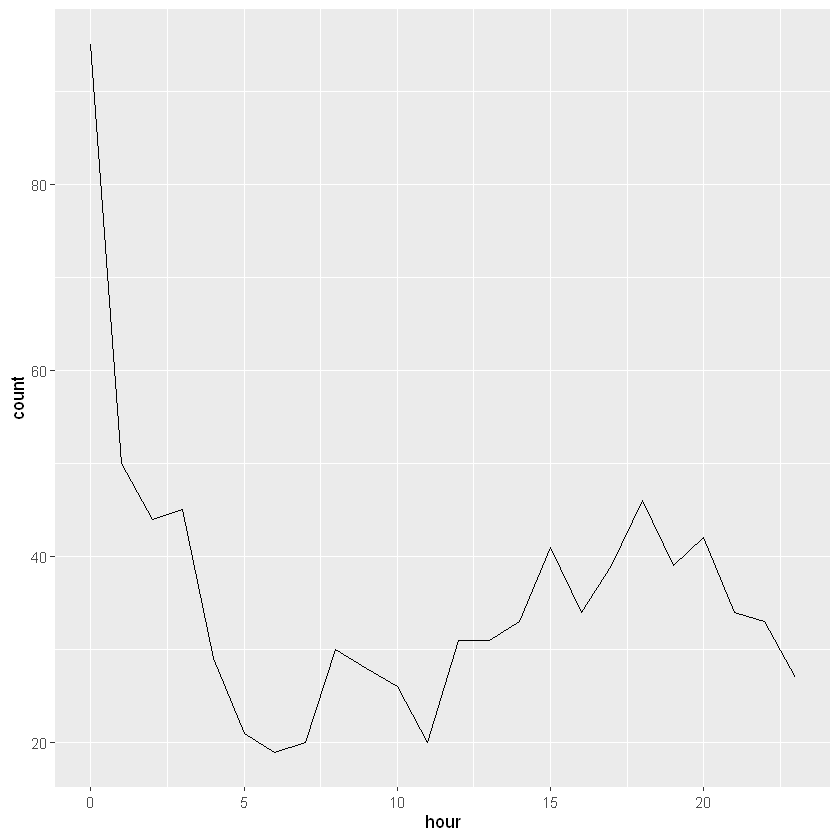

In [ ]:
# Extract the hour from the time_create field
# We'll also calculate a time period of day for later use
cfs <- cfs |> mutate(
  hour = hour(time_create), 
  time_period = case_when(
    hour >= 0 & hour <= 5 ~ "Night",
    hour >= 6 & hour <= 11 ~ "Morning",
    hour >= 12 & hour <= 17 ~ "Afternoon",
    hour >= 18 & hour <= 23 ~ "Evening"
  ), .after = time_create, 
)

# Generate a summary table by hour
hourly_sum <- cfs |> 
  count_table(hour) |> 
  arrange(hour)

# We can use ggplot() + geom_line()
ggplot(hourly_sum, aes(x = hour, y = count)) +
  geom_line()

In [ ]:
# Let's look at those time periods too
cfs |> count_table(time_period) |> affiche()

╔════╦═════════════╦═══════╦═════════╗ 
║ X. ║ time_period ║ count ║ percent ║ 
╠════╬═════════════╬═══════╬═════════╣ 
║ 1  ║ Night       ║ 284   ║ 33%     ║
║ 2  ║ Evening     ║ 221   ║ 26%     ║
║ 3  ║ Afternoon   ║ 209   ║ 24%     ║
║ 4  ║ Morning     ║ 143   ║ 17%     ║ 
╚════╩═════════════╩═══════╩═════════╝ 


#### 4. What are the most common call dispositions?

In [373]:
cfs |> count_table(disposition_text) |> affiche()

╔════╦═════════════════════════════╦═══════╦═════════╗ 
║ X. ║ disposition_text            ║ count ║ percent ║ 
╠════╬═════════════════════════════╬═══════╬═════════╣ 
║ 1  ║ Necessary action taken      ║ 436   ║ 51%     ║
║ 2  ║ Report to follow            ║ 174   ║ 20%     ║
║ 3  ║ Gone on arrival             ║ 170   ║ 20%     ║
║ 4  ║ Void                        ║ 36    ║ 4%      ║
║ 5  ║ Duplicate                   ║ 31    ║ 4%      ║
║ 6  ║ Referred to external agency ║ 6     ║ 1%      ║
║ 7  ║ Unfounded                   ║ 3     ║ <1%     ║
║ 8  ║ Canceled by complainant     ║ 1     ║ <1%     ║ 
╚════╩═════════════════════════════╩═══════╩═════════╝ 


#### 5. Which police districts receive the most calls?

In [374]:
cfs |> count_table(police_district) |> affiche()

╔════╦═════════════════╦═══════╦═════════╗ 
║ X. ║ police_district ║ count ║ percent ║ 
╠════╬═════════════════╬═══════╬═════════╣ 
║ 1  ║ 8               ║ 193   ║ 23%     ║
║ 2  ║ 3               ║ 137   ║ 16%     ║
║ 3  ║ 7               ║ 119   ║ 14%     ║
║ 4  ║ 1               ║ 101   ║ 12%     ║
║ 5  ║ 6               ║ 89    ║ 10%     ║
║ 6  ║ 2               ║ 79    ║ 9%      ║
║ 7  ║ 5               ║ 76    ║ 9%      ║
║ 8  ║ 4               ║ 55    ║ 6%      ║
║ 9  ║ NA              ║ 8     ║ 1%      ║ 
╚════╩═════════════════╩═══════╩═════════╝ 


#### 6. What proportion of calls are self-initiated?

In [375]:
cfs |> count_table(self_initiated) |> affiche()

╔════╦════════════════╦═══════╦═════════╗ 
║ X. ║ self_initiated ║ count ║ percent ║ 
╠════╬════════════════╬═══════╬═════════╣ 
║ 1  ║ FALSE          ║ 646   ║ 75%     ║
║ 2  ║ TRUE           ║ 211   ║ 25%     ║ 
╚════╩════════════════╩═══════╩═════════╝ 


#### 7. Where do most calls originate from?

Reading layer `tl_2024_22_bg' from data source 
  `C:\Users\cburruss\Documents\Git-Space-Nine\Data Analysis in Python for R Users\data\shapes\tl_2024_22_bg.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 4294 features and 13 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -94.04335 ymin: 28.85513 xmax: -88.75839 ymax: 33.01962
Geodetic CRS:  NAD83


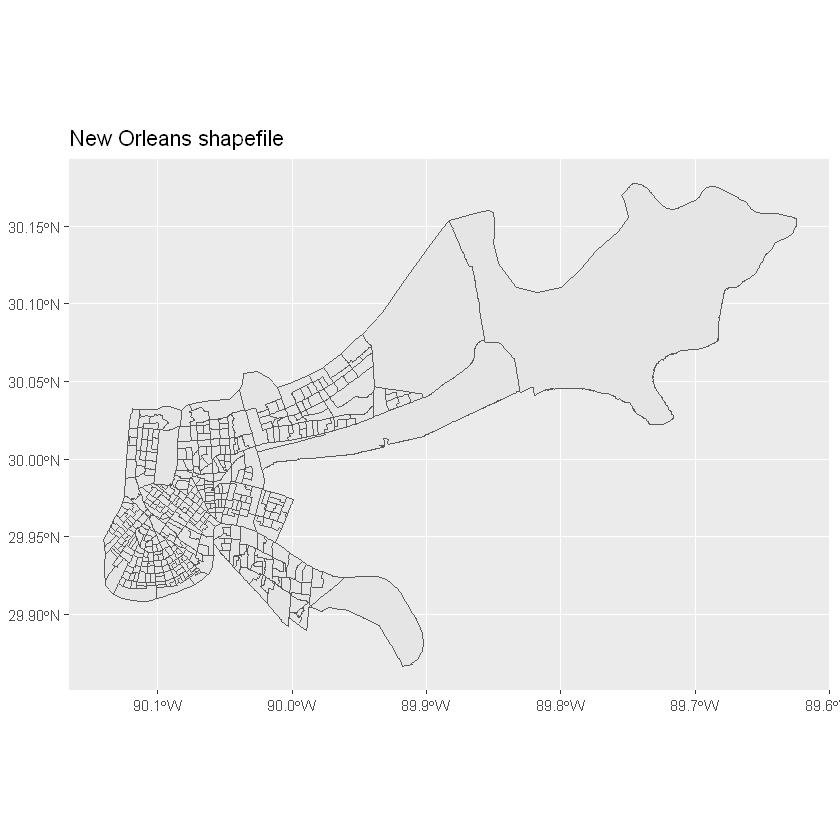

In [ ]:
if (!require(sf)) install.packages("sf")

# Read shapefile and filter to Orleans Parish
# As well as filter out water-only polygons
shapes <- sf::st_read("./data/shapes/tl_2024_22_bg.shp") |> 
  filter(COUNTYFP == "071") |> 
  filter(!grepl("220719900000|220719801001", GEOID))

# Preview the orleans shapes map
ggplot(shapes, aes()) +
  geom_sf() +
  labs(title = "New Orleans shapefile")

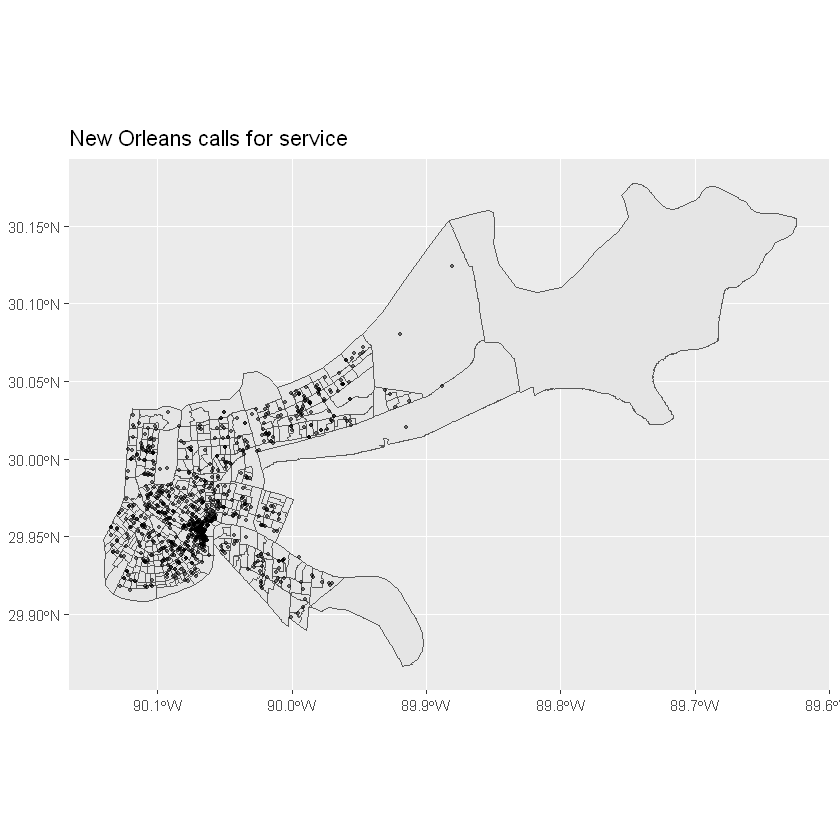

In [ ]:
# Convert the cfs object to a spatial feature (sf) object
cfs_sf <- cfs %>%
  st_as_sf(coords = c("longitude", "latitude"), crs = 4326, agr = "constant")

# Look at the shapes map with cfs overlaid
ggplot() +
  geom_sf(data = shapes) +
  geom_sf(data = cfs_sf, alpha = .5, size = .75) +
  labs(title = "New Orleans calls for service")

#### 8. What is the best predictor of response time?

In [394]:
# Note: I only included variables that were statistically significant for readability
# As well as convert response time to a true numeric column (in seconds)
# We'll also convert character fields and police district to factors
# And drop NAs
data <- cfs |> 
  select(c(category, priority_desc, time_period, response_time, 
           self_initiated, police_district)) |> 
  mutate(response_time = round(as.numeric(response_time), 0)) |> 
  mutate(across(where(is.character), as.factor)) |> 
  mutate(police_district = as.factor(police_district)) |> 
  drop_na()

str(data)

tibble [406 × 6] (S3: tbl_df/tbl/data.frame)
 $ category       : Factor w/ 4 levels "Other","Theft",..: 3 1 1 1 1 1 4 1 1 1 ...
 $ priority_desc  : Factor w/ 4 levels "Emergency","Non-emergency",..: 2 2 2 2 2 2 2 2 2 1 ...
 $ time_period    : Factor w/ 4 levels "Afternoon","Evening",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ response_time  : num [1:406] 11431 2997 3286 6685 1352 ...
 $ self_initiated : logi [1:406] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ police_district: Factor w/ 8 levels "1","2","3","4",..: 8 3 5 5 4 3 2 5 7 2 ...


In [399]:
# Fit a multiple linear regression model
model <- lm(formula = response_time ~ ., data = data)

# TO-DO: Invesitage why model outputs differ
model |> summary()


Call:
lm(formula = response_time ~ ., data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-16873  -4486  -1699   1706  94870 

Coefficients: (1 not defined because of singularities)
                                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -1764.430   1856.089  -0.951  0.34239    
categoryTheft                    6533.750   2119.309   3.083  0.00220 ** 
categoryTraffic                 -1537.766   2006.990  -0.766  0.44402    
categoryViolent                  3227.778   1905.654   1.694  0.09111 .  
priority_descNon-emergency       4826.391   1218.696   3.960  8.9e-05 ***
priority_descNon-police          3891.362   3184.197   1.222  0.22242    
priority_descOfficer assistance -5039.968  10521.878  -0.479  0.63221    
time_periodEvening                240.442   1438.368   0.167  0.86733    
time_periodMorning               3225.603   1621.106   1.990  0.04732 *  
time_periodNight                 1948.793   1368.815   1.424  0.1553